## This notebook is to prepare the txt for making word clouds of each genre

#### Instead of generating word clouds with python packages, we choose to use the website https://wordart.com/, for aesthetic reasons.

#### We start by throwing all the words that ever appear in a song genre into word clouds, but then find that they look almost identical

#### To fix this problem, we make cmf plots for word frequency of each genre. The reason why the genres look identical, is that the words which have the highest frequency (and thus would appear with biggest fonts in word clouds) are commonly shared across genres. Moreover, the cmf plots show that the 50 most frequently used words make up ~40% of the total words in each genre.

#### We then remove the top 50 words, and 100 words, respectively, to make 2 new sets of word clouds. The second set (when the top 100 words are taken out), shows more color of each genre. So we decide to present this set.

In [7]:
import pandas as pd
import numpy as np

lyrics = pd.read_csv("lyrics_cleaned_desc_by_count.csv")
songs = pd.read_csv("merged_dropdup.csv")

In [2]:
#the function to correct spellings, make exception for common contractioni words
import re
def words(text): return re.findall(r'\w+', text.lower())
from collections import Counter
WORDS = Counter(words(open('big.txt').read()))
####add additional words to keep "gonna", "wanna", etc.
additional_words = pd.read_csv('contraction.txt', sep='\t', header=None)[0].tolist()[:-2]
additional_words = list(map(lambda w: w.split()[0], additional_words))
additional_words.append('wanna')
WORDS.update(additional_words)


def correct_spelling(word):

    def P(word, N=sum(WORDS.values())): 
        "Probability of `word`."
        return WORDS[word] / N  
    
    def correction(word): 
        "Most probable spelling correction for word."
        return max(candidates(word), key=P)

    def candidates(word): 
        "Generate possible spelling corrections for word."
        return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

    def known(words): 
        "The subset of `words` that appear in the dictionary of WORDS."
        return set(w for w in words if w in WORDS)

    def edits1(word):
        "All edits that are one edit away from `word`."
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def edits2(word): 
        "All edits that are two edits away from `word`."
        return (e2 for e1 in edits1(word) for e2 in edits1(e1))
    
    return correction(word)

In [3]:
#prepare data for word analysis
#divide songs by genre, only keep artist_familiarity >= 0.5, 
#output is a txt with all the standardized wordsd

def prepare_data(genre):
    import codecs
    name = genre + '_lyrics.txt'
    genre_popular = songs[(songs['genre_merged'] == genre) & (songs['artist_familiarity']>=0.5)]

    #locate the blues songs in the lyrics dataset
    #use the track_id as the key 
    genre_lyrics = lyrics.merge(genre_popular, left_on="track_id", right_on="track_id", how='inner')
    genre_lyrics['word_corrected'] = genre_lyrics['word'].map(lambda x: correct_spelling(x))
    
    lst = []
    for _, row in genre_lyrics.iterrows():
        lst += [row['word_corrected']] *row['count']
    lst

    with codecs.open(name, 'w', 'utf8') as f:
        for item in lst:
            f.write("%s\n" % item)


In [217]:
#genrate the word list
genre_list = ['blues','country','jazz','indie','electronic','hiphop',
              'folk','metal','pop','punk','rap','rock','soul','classic rock']
for s in genre_list:
    prepare_data(s)
    print(s, ' done')

In [4]:
#calculate word frequency for different genres,output is series
def word_freq(genre):
    file_name = genre+'_lyrics.txt'
    df = pd.read_csv(file_name, sep='\t', names=['word'])
    new_series = df['word'].value_counts(normalize=True)
    return new_series

In [5]:
#cmf of word freqency
def word_cmf(genre):
    import matplotlib.pyplot as plt
    tmp = word_freq(genre).sort_values(ascending=False).reset_index()
    x = np.asarray((tmp.index + 1).tolist())
    y = np.asarray(tmp['word'])#.map(lambda x: math.log(x))
    z = np.cumsum(y)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,3))
    ax1.plot(x, z)
    ax1.set_title(genre +' word frequency cmf')
    mask = z <= 0.5
    ax2.plot(x[mask], z[mask])
    ax2.set_title('zoom in')
    ax1.set_ylabel('cumulative frequency')
    ax1.set_xlabel('word rank')
    ax2.set_xlabel('word rank for words that make up 50% of total words')
    plt.savefig(genre+'_cmf.jpg')

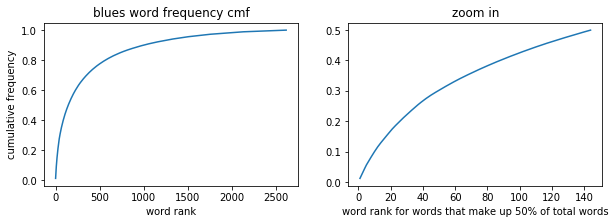

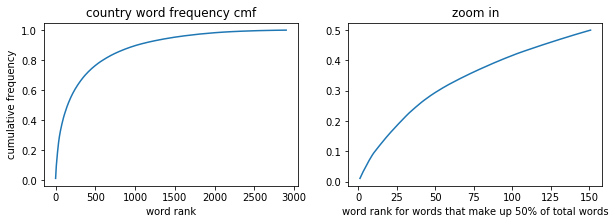

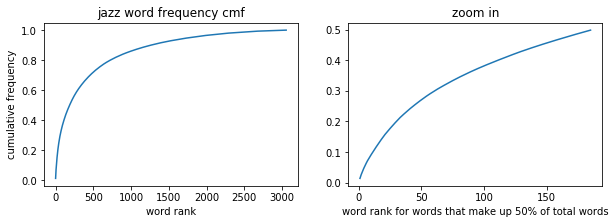

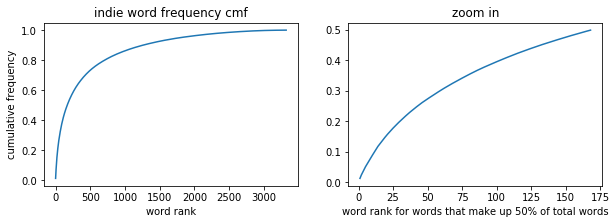

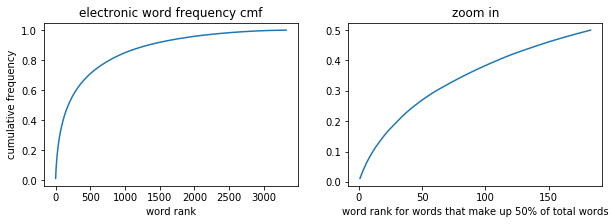

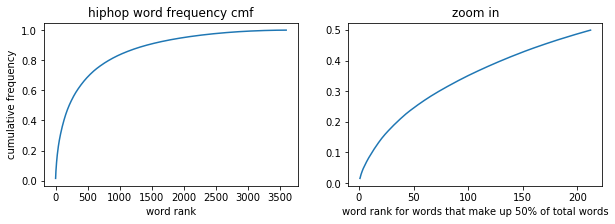

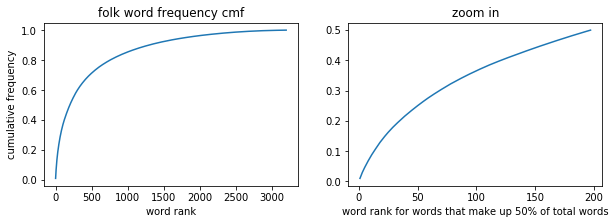

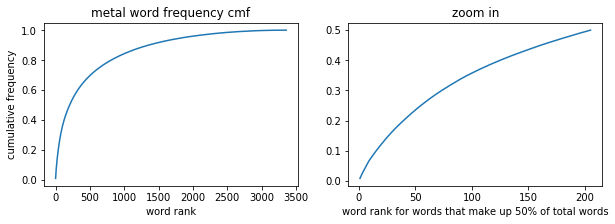

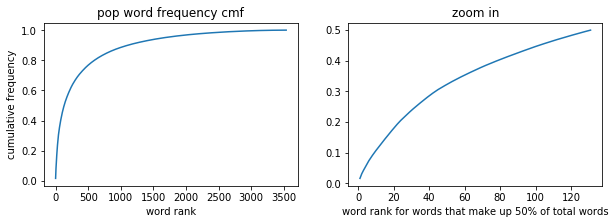

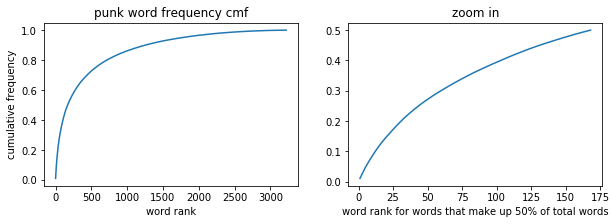

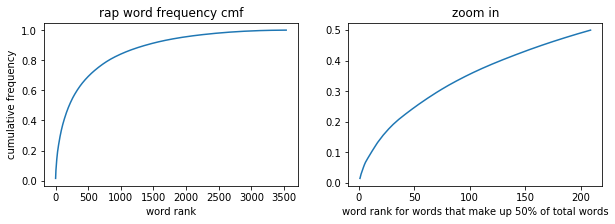

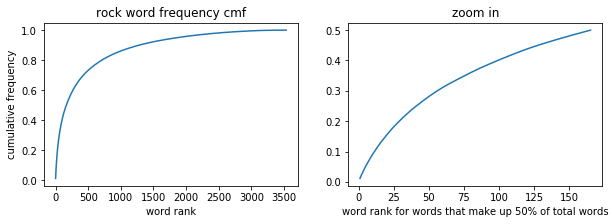

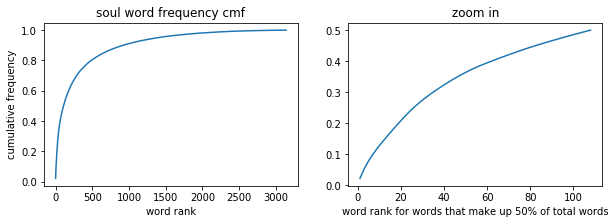

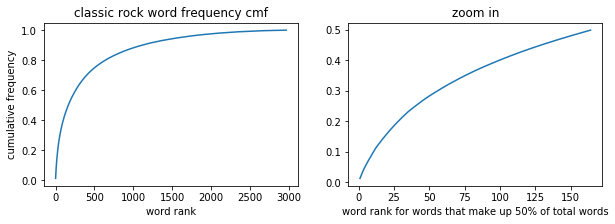

In [8]:
#make the graph for all the genres

l = ['blues','country','jazz','indie','electronic','hiphop',
     'folk','metal','pop','punk','rap','rock','soul','classic rock']
for s in l:
    word_cmf(s)

In [261]:
#prepare the text for word cloud the second time
#choose the less frequent words

#choose the 51+
def word_after50(genre):
    import codecs
    file_name = genre+'_lyrics.txt'
    df = pd.read_csv(file_name, sep='\t', names=['word'])
    df = df['word'].value_counts()
    df = df.reset_index()
    df = df[50:len(df)]
    df = df.rename(index=str, columns={"index": "words", "word": "count"})

    lst = []
    for _, row in df.iterrows():
        lst += [row['words']] *row['count']

    with codecs.open(genre+'_word_after50', 'w', 'utf8') as f:
        for item in lst:
            f.write("%s\n" % item)

#if we want to choose the 100+ words
def word_after100(genre):
    import codecs
    file_name = genre+'_lyrics.txt'
    df = pd.read_csv(file_name, sep='\t', names=['word'])
    df = df['word'].value_counts()
    df = df.reset_index()
    df = df[100:len(df)]
    df = df.rename(index=str, columns={"index": "words", "word": "count"})

    lst = []
    for _, row in df.iterrows():
        lst += [row['words']] *row['count']

    with codecs.open(genre+'_word_after100', 'w', 'utf8') as f:
        for item in lst:
            f.write("%s\n" % item)

In [263]:
#genrate all the txt
l = ['blues','country','jazz','indie','electronic','hiphop',
     'folk','metal','pop','punk','rap','rock','soul','classic rock']
for s in l:
    word_after50(s)
    word_after100(s)
              